# Joseph Korban's Notebook

## Goal: DL Model

#### Preliminary Steps

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf

df = pd.read_csv('/Users/joekorban/code/J0eDub/crypto_market_assistant/Raw Data/BTCUSDT_daily_Binance.csv')

df_droptime = df.drop(columns='time')

df_droptime.head()


,open,high,low,close,volume BTC,volume USD
0,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06
1,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06
2,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06
3,4139.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06
4,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06


#### Assignments: 
- Targets  
- Number of targets 
- Number of features


In [2]:
# Can change later

N_FEATURES = df_droptime.shape[1]  # All features other than time
N_TARGETS = 1                      # Prediciting only 1 target (close price)
TARGET = 'close'


## Preparing the dataset for DL Model

### Step 1. Creating many folds

#### Assignments: 
- Fold Length   
- Fold Size
- Train Test Ratio


In [3]:
# Can change later

# Since we have data for about 6.3 years, we will asssume fold lengths of 2 years
# 1.34 years for training and 0.67 for testing

FOLD_LENGTH = 365 * 2     # Assume fold legnth of 2 years
FOLD_STRIDE = 91          # Assume stride every quarter
TRAIN_TEST_RATIO = 0.67   # Two-thirds split ratio


#### * Implement the Get Folds Function:
- Takes in df, fold length, fold stride
- Returns a list of folds (each fold being a dataframe)

In [4]:
# Goes through the dataframe and creates equal sized folds of FOLD_LENGTH
# starting at 0 and at each FOLD_STRIDE until it crosses len(df)

def get_folds(df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:

    folds = []
    for index in range(0, fold_length, fold_stride):
        if index + fold_length > len(df):
            break
        fold = df.iloc[index:index + fold_length,:]
        folds.append(fold)
    return folds


In [5]:
folds = (get_folds(df_droptime,FOLD_LENGTH,FOLD_STRIDE))
print(f'Number of folds created were {len(folds)}')
print(f'Each with a shape equal to {folds[0].shape}.')


Number of folds created were 9
Each with a shape equal to (730, 6).


### Step 2. Temporal Train Test Split for one fold 

#### Focusing on one fold first 

In [6]:
fold = folds[0]


#### Assignments: 
- Input Length : Selected period selected for forecasting
- Output Length : Selected period we want to predict


In [7]:
# Can change later

INPUT_LENGTH = 30           # We can assume one month for a forecating period
OUTPUT_LENGTH = 1           # If we want predict only one timestep (day) ahead
TEMP_TRAIN_TEST_RATIO = 0.8 # How we want to split each fold (can be same as train test ratio)


#### * Implement the Temporal Train Test Split Function:
- Takes in a fold, temporal train test ratio, input length
- Returns a tuple of (fold_train, fold_test), each as a dataframe

In [8]:
# Splitting one fold into train and test chronologically,
# so we can later sample many (Xi,yi) pairs (input and output lengths)

def temporal_train_test_split(fold:pd.DataFrame,
                            temp_train_test_ratio: float,
                            input_length: int) -> tuple[pd.DataFrame]:
    # Train set
    last_train_index = round(temp_train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_index, :]

    #Test Set
    first_test_index = last_train_index - input_length
    fold_test = fold.iloc[first_test_index:, :]

    return (fold_train,fold_test)


In [9]:
(fold_train, fold_test) = temporal_train_test_split(fold, TEMP_TRAIN_TEST_RATIO, INPUT_LENGTH)


In [10]:
fold_train.shape, fold_test.shape


((584, 6), (176, 6))

### Step 3. Create (X, y) sequences

#### Now that we split our fold into trian and test we have to create 2 functions 
- One that will return a single sequence of (Xi, yi) (from fold train for training, and from fold test for evaluating)
- Another that will call the first function many times over creating 3-D arrays of multiple sequences (X, y)

#### * Implement the Get (Xi, yi) function (using the random method):
- Takes in a fold, input length ,output length
- Returns a single sequence of (Xi, yi) as a 2-D DataFrame

In [11]:
# Given a fold (could be train fold for testing or test fold for evaluating),
# it will return a sequence of (Xi,yi) based on input and output lengths,
# starting from a random point.

def get_Xi_yi(fold:pd.DataFrame,
              input_length:int,
              output_length:int):

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]

    return (X_i, y_i)


In [12]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)


In [13]:
X_train_i.shape, y_train_i.shape


((30, 6), (1, 1))

In [14]:
X_test_i.shape, y_test_i.shape


((30, 6), (1, 1))

#### Assignments: 
- Number of sequences train : How many sequences do we want to collect from X_train
- Number of sequences test : How many sequences do we want to collect from X_test


In [15]:
# Can change later

N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test


#### * Implement the Get (X,y) Function:
- Takes in fold, number of sequences, input length, output length
- Returns (X, y) as a 3-D array

In [16]:
# Uses the previous get_Xi_yi function and loops based on number of sequences,
# and returns your complete X_train, y_train as 3-D arrays of
#( Number of sequences, time steps, number of features(targets) )

def get_X_y(fold:pd.DataFrame,
            number_of_sequences:int,
            input_length:int,
            output_length:int):

    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)


In [34]:
X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)


In [18]:
X_train.shape, y_train.shape


((6666, 30, 6), (6666, 1, 1))

In [19]:
X_test.shape, y_test.shape


((3333, 30, 6), (3333, 1, 1))

## Modeling

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda


### Step 1. Building a Baseline (dummy) model for comparisons

#### * Initialize the Baseline Model function based on last seen value

In [21]:
def init_baseline():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mse",'mae'])

    return model


In [22]:
base_model = init_baseline()
base_model.fit(X_train,y_train)


 88/209 [===========>..................] - ETA: 0s - loss: 363063.8438 - mse: 363063.8438 - mae: 350.5678 

209/209 [==============================] - 0s 575us/step - loss: 377755.4688 - mse: 377755.4688 - mae: 358.0751


In [23]:
baseline_score = base_model.evaluate(X_test,y_test)


105/105 [==============================] - 0s 529us/step - loss: 306864.7812 - mse: 306864.7812 - mae: 357.0074


### Step 2. Building an LSTM Model

#### * Initialize the LSTM Model function

In [24]:
def init_model(X_train, y_train):

    adam = optimizers.Adam(learning_rate=0.01)

    output_length = y_train.shape[1]*y_train.shape[2]

    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()

    model.add(normalizer)
    model.add(layers.LSTM(250,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(125,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(50,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(75,
                          activation='tanh',
                          return_sequences = False,
                          ))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(output_length, activation='linear'))

    model.compile(loss='mse', optimizer=adam, metrics=["mse",'mae'])

    return model


#### * Fit (Train) the LSTM Model function

In [25]:
def fit_model(model: tf.keras.Model, verbose=1) -> tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 15,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [es],
                        verbose = verbose)

    return model, history


#### * Define the plot history function

In [26]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax


In [27]:
model = init_model(X_train, y_train)
model.summary()

model, history = fit_model(model)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, None, 6)           13        
 on)                                                             
                                                                 
 lstm (LSTM)                 (None, None, 250)         257000    
                                                                 
 lstm_1 (LSTM)               (None, None, 125)         188000    
                                                                 
 lstm_2 (LSTM)               (None, None, 50)          35200     
                                                                 
 lstm_3 (LSTM)               (None, 75)                37800     
                                                                 
 dense (Dense)               (None, 10)                760       
                                                      

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

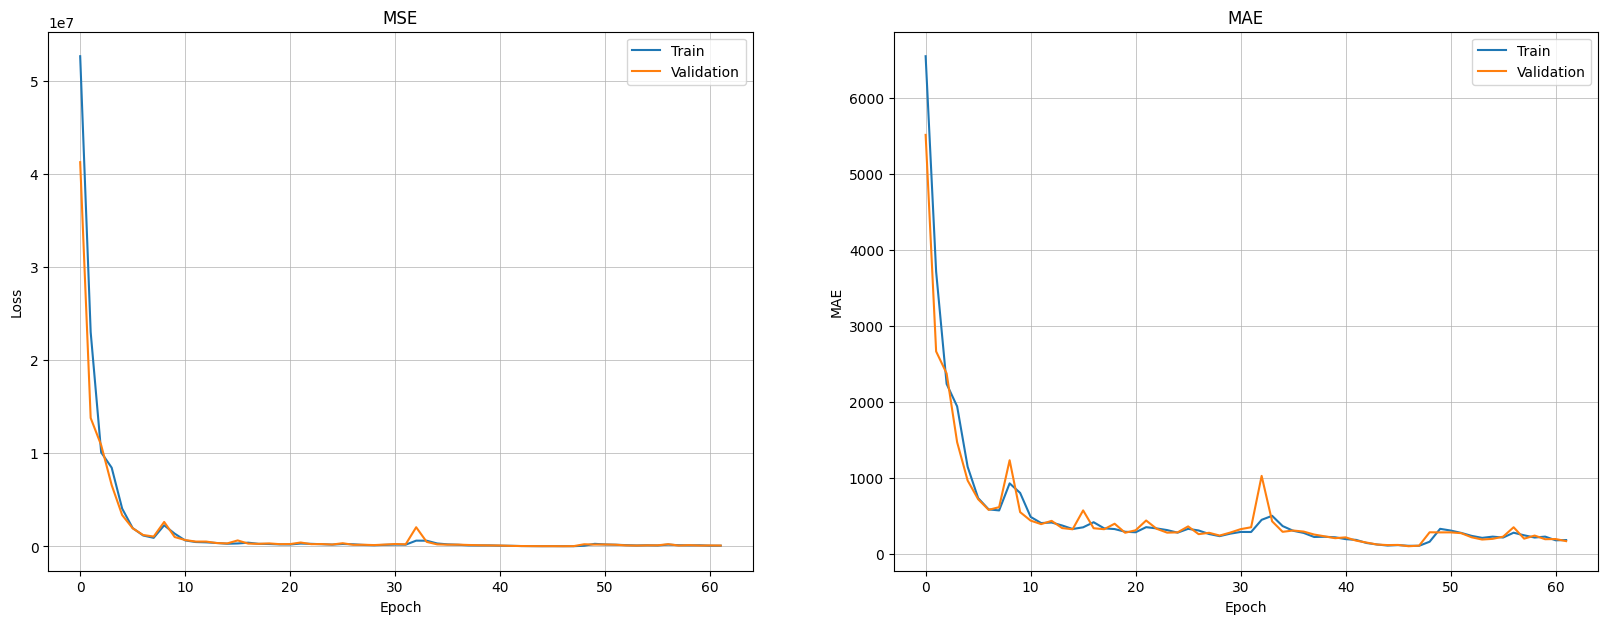

In [28]:
plot_history(history)


In [29]:
res = model.evaluate(X_test,y_test)


105/105 [==============================] - 2s 24ms/step - loss: 790492.0000 - mse: 790492.0000 - mae: 692.8980


#### All this was for one fold, now we need to Cross validate on all folds

### Step 3. Cross Validation

#### * Funtion to Cross Validate for Baseline and LSTM Models in for loop

In [30]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(df_droptime, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold

        (fold_train, fold_test) = temporal_train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

        # 2 - Modelling

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[2]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        history = fit_model(model)
        # es = EarlyStopping(monitor = "val_mae",
        #                    mode = "min",
        #                    patience = 2,
        #                    restore_best_weights = True)
        # history = model.fit(X_train, y_train,
        #                     validation_split = 0.3,
        #                     shuffle = False,
        #                     batch_size = 32,
        #                     epochs = 50,
        #                     callbacks = [es],
        #                     verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[2]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


In [31]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()


--------------------------------------------------
MAE baseline fold n°0 = 256.21
Epoch 1/100
146/146 [==============================] - 18s 101ms/step - loss: 49229072.0000 - mse: 49229072.0000 - mae: 6252.5454 - val_loss: 31142864.0000 - val_mse: 31142864.0000 - val_mae: 4507.3857
Epoch 2/100
146/146 [==============================] - 15s 102ms/step - loss: 15141133.0000 - mse: 15141133.0000 - mae: 2807.4680 - val_loss: 11030685.0000 - val_mse: 11030685.0000 - val_mae: 2342.8779
Epoch 3/100
146/146 [==============================] - 13s 92ms/step - loss: 9529016.0000 - mse: 9529016.0000 - mae: 2236.5776 - val_loss: 10831817.0000 - val_mse: 10831817.0000 - val_mae: 2403.2678
Epoch 4/100
146/146 [==============================] - 14s 94ms/step - loss: 9475884.0000 - mse: 9475884.0000 - mae: 2220.9141 - val_loss: 11001474.0000 - val_mse: 11001474.0000 - val_mae: 2346.8921
Epoch 5/100
146/146 [==============================] - 14s 95ms/step - loss: 9430070.0000 - mse: 9430070.0000 - mae:

--------------------------------------------------
MAE baseline fold n°1 = 345.39
Epoch 1/100
146/146 [==============================] - 18s 105ms/step - loss: 53934692.0000 - mse: 53934692.0000 - mae: 6655.3374 - val_loss: 45009968.0000 - val_mse: 45009968.0000 - val_mae: 5846.6768
Epoch 2/100
146/146 [==============================] - 14s 99ms/step - loss: 27230836.0000 - mse: 27230836.0000 - mae: 4170.4858 - val_loss: 16800862.0000 - val_mse: 16800862.0000 - val_mae: 2983.3723
Epoch 3/100
146/146 [==============================] - 15s 105ms/step - loss: 11093452.0000 - mse: 11093452.0000 - mae: 2356.4175 - val_loss: 10994063.0000 - val_mse: 10994063.0000 - val_mae: 2348.0042
Epoch 4/100
146/146 [==============================] - 17s 113ms/step - loss: 12168364.0000 - mse: 12168364.0000 - mae: 2529.7102 - val_loss: 36613656.0000 - val_mse: 36613656.0000 - val_mae: 4916.4492
Epoch 5/100
146/146 [==============================] - 16s 111ms/step - loss: 19297190.0000 - mse: 19297190.000

--------------------------------------------------
MAE baseline fold n°2 = 345.88
Epoch 1/100
146/146 [==============================] - 18s 106ms/step - loss: 54830644.0000 - mse: 54830644.0000 - mae: 6726.4580 - val_loss: 48465852.0000 - val_mse: 48465852.0000 - val_mae: 6135.1060
Epoch 2/100
146/146 [==============================] - 15s 105ms/step - loss: 32710786.0000 - mse: 32710786.0000 - mae: 4758.9312 - val_loss: 22520710.0000 - val_mse: 22520710.0000 - val_mae: 3484.1174
Epoch 3/100
146/146 [==============================] - 15s 105ms/step - loss: 13965418.0000 - mse: 13965418.0000 - mae: 2699.4299 - val_loss: 11858201.0000 - val_mse: 11858201.0000 - val_mae: 2401.2979
Epoch 4/100
146/146 [==============================] - 14s 94ms/step - loss: 9724272.0000 - mse: 9724272.0000 - mae: 2197.3652 - val_loss: 10871075.0000 - val_mse: 10871075.0000 - val_mae: 2376.3684
Epoch 5/100
146/146 [==============================] - 16s 109ms/step - loss: 18982974.0000 - mse: 18982974.0000 

--------------------------------------------------
MAE baseline fold n°3 = 310.44
Epoch 1/100
146/146 [==============================] - 16s 93ms/step - loss: 53080880.0000 - mse: 53080880.0000 - mae: 6585.9136 - val_loss: 41996264.0000 - val_mse: 41996264.0000 - val_mae: 5583.0049
Epoch 2/100
146/146 [==============================] - 13s 90ms/step - loss: 23523624.0000 - mse: 23523624.0000 - mae: 3774.1809 - val_loss: 14002861.0000 - val_mse: 14002861.0000 - val_mae: 2695.2793
Epoch 3/100
146/146 [==============================] - 13s 91ms/step - loss: 10146803.0000 - mse: 10146803.0000 - mae: 2247.0442 - val_loss: 10869162.0000 - val_mse: 10869162.0000 - val_mae: 2377.3718
Epoch 4/100
146/146 [==============================] - 13s 92ms/step - loss: 9513840.0000 - mse: 9513840.0000 - mae: 2245.6211 - val_loss: 10833304.0000 - val_mse: 10833304.0000 - val_mae: 2401.2786
Epoch 5/100
146/146 [==============================] - 13s 91ms/step - loss: 11886431.0000 - mse: 11886431.0000 - ma

--------------------------------------------------
MAE baseline fold n°4 = 291.89
Epoch 1/100
146/146 [==============================] - 17s 96ms/step - loss: 51614800.0000 - mse: 51614800.0000 - mae: 6467.7334 - val_loss: 39080040.0000 - val_mse: 39080040.0000 - val_mae: 5315.4224
Epoch 2/100
146/146 [==============================] - 13s 86ms/step - loss: 21099892.0000 - mse: 21099892.0000 - mae: 3503.5149 - val_loss: 12771524.0000 - val_mse: 12771524.0000 - val_mae: 2536.3379
Epoch 3/100
146/146 [==============================] - 14s 93ms/step - loss: 9834916.0000 - mse: 9834916.0000 - mae: 2217.6479 - val_loss: 10846620.0000 - val_mse: 10846620.0000 - val_mae: 2389.2585
Epoch 4/100
146/146 [==============================] - 13s 90ms/step - loss: 21434700.0000 - mse: 21434700.0000 - mae: 3747.3413 - val_loss: 25855228.0000 - val_mse: 25855228.0000 - val_mae: 4275.4341
Epoch 5/100
146/146 [==============================] - 13s 91ms/step - loss: 30427602.0000 - mse: 30427602.0000 - ma

--------------------------------------------------
MAE baseline fold n°5 = 260.99
Epoch 1/100
146/146 [==============================] - 16s 91ms/step - loss: 50303988.0000 - mse: 50303988.0000 - mae: 6357.0479 - val_loss: 35728992.0000 - val_mse: 35728992.0000 - val_mae: 4990.2568
Epoch 2/100
146/146 [==============================] - 13s 88ms/step - loss: 18275306.0000 - mse: 18275306.0000 - mae: 3178.1506 - val_loss: 11705836.0000 - val_mse: 11705836.0000 - val_mae: 2378.3979
Epoch 3/100
146/146 [==============================] - 12s 83ms/step - loss: 9623505.0000 - mse: 9623505.0000 - mae: 2214.0088 - val_loss: 10835903.0000 - val_mse: 10835903.0000 - val_mae: 2398.2820
Epoch 4/100
146/146 [==============================] - 13s 86ms/step - loss: 9513269.0000 - mse: 9513269.0000 - mae: 2252.2983 - val_loss: 10831670.0000 - val_mse: 10831670.0000 - val_mae: 2403.4578
Epoch 5/100
146/146 [==============================] - 13s 88ms/step - loss: 9513791.0000 - mse: 9513791.0000 - mae: 2

--------------------------------------------------
MAE baseline fold n°6 = 644.79
Epoch 1/100
146/146 [==============================] - 16s 91ms/step - loss: 52663924.0000 - mse: 52663924.0000 - mae: 6553.0361 - val_loss: 41355584.0000 - val_mse: 41355584.0000 - val_mae: 5525.3301
Epoch 2/100
146/146 [==============================] - 14s 96ms/step - loss: 23091822.0000 - mse: 23091822.0000 - mae: 3726.9485 - val_loss: 13828682.0000 - val_mse: 13828682.0000 - val_mae: 2673.8435
Epoch 3/100
146/146 [==============================] - 14s 97ms/step - loss: 10102846.0000 - mse: 10102846.0000 - mae: 2242.1497 - val_loss: 10866281.0000 - val_mse: 10866281.0000 - val_mae: 2378.5640
Epoch 4/100
146/146 [==============================] - 14s 95ms/step - loss: 9700375.0000 - mse: 9700375.0000 - mae: 2232.2256 - val_loss: 10847182.0000 - val_mse: 10847182.0000 - val_mae: 2388.8713
Epoch 5/100
146/146 [==============================] - 15s 104ms/step - loss: 9513385.0000 - mse: 9513385.0000 - mae

--------------------------------------------------
MAE baseline fold n°7 = 1475.07
Epoch 1/100
146/146 [==============================] - 16s 86ms/step - loss: 56862468.0000 - mse: 56862468.0000 - mae: 6879.4932 - val_loss: 53287316.0000 - val_mse: 53287316.0000 - val_mae: 6516.2095
Epoch 2/100
146/146 [==============================] - 12s 84ms/step - loss: 39581532.0000 - mse: 39581532.0000 - mae: 5453.3330 - val_loss: 30416490.0000 - val_mse: 30416490.0000 - val_mae: 4426.0781
Epoch 3/100
146/146 [==============================] - 13s 86ms/step - loss: 19464904.0000 - mse: 19464904.0000 - mae: 3310.8745 - val_loss: 14872492.0000 - val_mse: 14872492.0000 - val_mae: 2794.7622
Epoch 4/100
146/146 [==============================] - 12s 86ms/step - loss: 10856620.0000 - mse: 10856620.0000 - mae: 2325.6816 - val_loss: 11174054.0000 - val_mse: 11174054.0000 - val_mae: 2334.4666
Epoch 5/100
146/146 [==============================] - 12s 83ms/step - loss: 9572759.0000 - mse: 9572759.0000 - m

--------------------------------------------------
MAE baseline fold n°8 = 1981.5
Epoch 1/100
146/146 [==============================] - 14s 79ms/step - loss: 55552916.0000 - mse: 55552916.0000 - mae: 6781.1128 - val_loss: 49726968.0000 - val_mse: 49726968.0000 - val_mae: 6237.0381
Epoch 2/100
146/146 [==============================] - 11s 79ms/step - loss: 33887012.0000 - mse: 33887012.0000 - mae: 4880.4189 - val_loss: 23451618.0000 - val_mse: 23451618.0000 - val_mae: 3585.1250
Epoch 3/100
146/146 [==============================] - 11s 77ms/step - loss: 14446675.0000 - mse: 14446675.0000 - mae: 2752.6626 - val_loss: 12020983.0000 - val_mse: 12020983.0000 - val_mae: 2426.4363
Epoch 4/100
146/146 [==============================] - 11s 77ms/step - loss: 9768289.0000 - mse: 9768289.0000 - mae: 2198.6221 - val_loss: 10878747.0000 - val_mse: 10878747.0000 - val_mae: 2373.7888
Epoch 5/100
146/146 [==============================] - 11s 78ms/step - loss: 9513682.0000 - mse: 9513682.0000 - mae:

In [32]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")


average percentage improvement over baseline = -494.00000000000006%
